# Import package

In [1]:
import numpy as np
from numpy import nan
from numpy import isnan
from numpy import split
from numpy import array
from numpy import concatenate

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

import matplotlib.pyplot as plt
from matplotlib import pyplot
from pylab import *
plt.rcParams['font.sans-serif'] = ['SimHei']

import math
from math import sqrt

import re
import tqdm
import random
import os
import itertools
import argparse
import joblib
import xlrd
from collections import defaultdict
import copy

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn import datasets

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers

import datetime
import calendar
import time
from datetime import date,datetime

import xgboost as xgb
from xgboost import plot_importance, plot_tree

import seaborn as sns
import stats as sts#df2

from scipy import stats
from scipy.special import softmax

from keras.models import load_model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

import torch
import torch.nn as nn


Bad key "nbagg.transparent" on line 426 in
D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_path" on line 509 in
D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_args" on line 512 in
D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution
In D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.

# Load data

In [2]:
abc=30#表示30min为一段
gdf0=pd.read_csv(r'F:\博士科研资料\博士开题及其素材\加油站数据\export11.csv',encoding='gb18030')
gdf0['Time1'] = pd.to_datetime(gdf0['Time'],errors='coerce') 
gdf0['Hour'] = gdf0['Time1'].dt.hour.fillna(0).astype("int")    #转化提取小时
gdf0['Minute'] = gdf0['Time1'].dt.minute.fillna(0).astype("int") #转化提取分钟
gdf0['Hour']=gdf0['Hour'].astype(str)
gdf0['Date'] = pd.to_datetime(gdf0['Date'])
gdf0['T'] = gdf0['Hour'].apply(lambda x : int(x))+gdf0['Minute'].apply (lambda x :round(x/60,2))
gdf0['volume'] = gdf0['volume']
gdf0['MinuteLabel']=gdf0['Hour'].apply(lambda x : math.floor((int(x)*60)/abc))+gdf0['Minute'].apply (lambda x :math.floor(x/abc))#表示该时刻点属于哪个区间,因为有0，所以向下取整数
day_name00=gdf0.groupby(["NAME"])         #
for name,group in day_name00:#group是星期数一样的类目
    if name=='92H':
        df0=group
df0=df0[df0['Date'] >= "2020-06-01"] 
df0= df0[~( df0['Date'].isin(["2020-06-11","2020-08-11", "2020-08-25", "2020-09-11"]) )]###删除这些行，因为很多0

# Data preprogressing

In [3]:
DFStockOut=df0.iloc[:,[6,7,11,3,10,12]]
c=3
a=DFStockOut.shape[1]
ReStartStock=13790#10000#该变量表示补货到达后的初始库存
DFStockOut['OurLeaveStock']=DFStockOut['Date'].apply(lambda x : ReStartStock)#6
DFStockOut['OurBuHuoStart']=DFStockOut['Date'].apply(lambda x : 0)#补货触发时刻7
b=a+1
DFStockOut['Date']=pd.to_datetime(DFStockOut['Date'])
StockOutTime=[]
DHCS1=0#表示订货次数
DFStockOut['AllMinutes']=DFStockOut['MinuteLabel'].apply(lambda x: time.strftime("%H:%M:%S", time.gmtime( float((x+1)*abc*60))))
for i in range(DFStockOut.shape[0]):
    if DFStockOut.iloc[i,-1]=="00:00:00": 
        DFStockOut.iloc[i,-1]="23:59:00"  ###1月20日0:00:00表示的是1月20日24:00:00,而无法取24h，所以设为23.59    
DFStockOut['timestamp']=DFStockOut['Date'].astype('str')+ ' ' + DFStockOut['AllMinutes'].astype('str')
DFStockOut['timestamp'] = pd.to_datetime(DFStockOut['timestamp'])#pd.to_datetime它无法转换
print(DFStockOut.shape)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

(207441, 10)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
D:\anaconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [4]:
df2 = df0.groupby(["Date","MinuteLabel"])['volume'].sum().reset_index(name ='UnitSales')#只留下小时销量数据
df2['Date'] = pd.to_datetime(df2['Date']) 
df2['Month_id']=df2['Date'].dt.month
df2['weekday'] = df2['Date'].apply(lambda time: time.dayofweek)
df2['MinuteLabel']=df2['MinuteLabel'].astype(str)
df2['weekday_hour'] = df2.weekday.astype(str) +' '+ df2.MinuteLabel.astype(str)
df2['m_weekday'] = df2.weekday_hour.replace(df2[:].groupby('weekday_hour')['UnitSales'].mean().to_dict())
init1 = df2.m_weekday[:].apply(np.log).values#均值取对数df5['UnitSales'
df2['PreproccessUnitSales'] =df2.UnitSales[:].apply(np.log).values - init1#数取对数-均值的对数
dfghu=df2.sort_values(by=['UnitSales'],ascending=[True]) 
df2['UnitSales']=df2['UnitSales'].apply(lambda x: (x-dfghu.iloc[0,2])/(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2]))
df2['MinuteLabel']=df2['MinuteLabel'].astype(int)#

In [5]:
idx=list(range(0,int(24*60/abc)))                                                         
i=0
colorSet=['cyan','g','palegreen','c','lime','tomato','r']
DayName=['Mony','Tues','Wednes', 'Thurs', 'Fri', 'Satur', 'Sun']
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_name=df2.groupby(["weekday"])         #
for name,group in day_name:#group是星期数一样的类目
    group1=group.groupby(["Date"])
    j=0
    for name,group2 in group1:#group2是星期数、日期数一样的类目，即一天  
         #display(group2.head(13))
         group2=group2.sort_values(by=['MinuteLabel'],ascending=True,na_position='first')  # 按时间排序                  
         group2 = group2.set_index('MinuteLabel')#group2设置索引为Hour         
         group2 = group2.reindex(idx, fill_value=0)
         group2['MinuteLabel'] = group2.index          
         group2['Date']=name
         group2['weekday'] = group2['Date'].apply(lambda time: time.dayofweek)
         group2['day_name']=group2['weekday'].apply (lambda x : days[x])
         if i==0 and j==0:
            df3=group2
         else:      
            df3=pd.concat([df3,group2], axis=0, ignore_index=True)#axis:合并方式，默认0表示按列合并，1表示按行合并;ignore_index:是否忽略索引                   
         j=j+1
    i=i+1
df3=df3.sort_values(by=['Date','MinuteLabel'],ascending=[True,True]) #df3是没有的，用0不足的dataframe
df3['HourLabel']=df3['MinuteLabel'].apply(lambda x: math.floor(x*abc/60))

In [6]:
df5=df3.iloc[:,:]
df3['HourLabel']=df3['HourLabel'].astype(int)
df5['weekday'] = df5.Date.dt.weekday
df5['weekday_hour'] = df5.weekday.astype(str) +' '+ df5.HourLabel.astype(str)
df5['m_weekday'] = df5.weekday_hour.replace(df5[:].groupby('weekday_hour')['UnitSales'].mean().to_dict())
df5.to_csv('hour_Demand_consumption.csv')
df = pd.DataFrame(columns=['timestamp', 'value'])###初始化
df5['AllMinutes']=df5['MinuteLabel'].apply(lambda x: time.strftime("%H:%M:%S", time.gmtime( float((x+1)*abc*60))))
for i in range(df5.shape[0]):
    if df5.loc[i,'AllMinutes']=="00:00:00": 
        df5.loc[i,'AllMinutes']="23:59:00"  ###1月20日0:00:00表示的是1月20日24:00:00,而无法取24h，所以设为23.59
df['timestamp']=df5['Date'].astype('str')+ ' ' + df5['AllMinutes'].astype('str')
df['timestamp'] = pd.to_datetime(df['timestamp'])#为什么成了选取偶数
df['value']=df5['UnitSales']
df=df.sort_values(by=['timestamp'],ascending=[True]) 
df['Date']=df['timestamp'].apply(lambda x: x.strftime("%Y-%m-%d"))#提取时间戳中的日期
df['MinuteLabel']=df5['MinuteLabel']
df['yr'] = df.timestamp.dt.year
df['mt'] = df.timestamp.dt.month
df['d'] = df.timestamp.dt.day
df['H'] = df5['HourLabel']
df['Mi'] = df5['MinuteLabel']#表示第几个单位时间
df['weekday'] = df.timestamp.dt.weekday
df['weekday_hour'] = df.weekday.astype(str) +' '+ df.Mi.astype(str)
df['m_weekday'] = df.weekday_hour.replace(df[:].groupby('weekday_hour')['value'].mean().to_dict())
df=df.sort_values(by=['timestamp','Mi'],ascending=[True,True]) #df3是没有的，用0不足的dataframe

# Calculate membership 

In [7]:
def CalCu_Member(DegreeOfDispersionResult,STR):##隶属度计算对应自定义函数
    y=list(DegreeOfDispersionResult.loc[:,STR])
    #print('y',y)
    import math
    YY=list(DegreeOfDispersionResult.loc[:,STR])
    MaxS=[]
    MinS=[]
    y.sort() 
    MinYY=min(y)#y[0]
    MaxYY=max(y)#y[-1]
    MaxMin=max(y)-min(y)#y[-1]-y[0]
    #print('MinYY,MaxYY,MaxMin',MinYY,MaxYY,MaxMin)
    #print('00MinYY,MaxYY,MaxMin',min(y),max(y),max(y)-min(y))
    JJJJJ=[]
    for i in range(len(YY)):
        JJJJJ.append([])
        MaxS.append(round(0.5+0.5*(math.sin((math.pi /MaxMin)*(YY[i]-MaxMin/2))),4))
        MinS.append(round(0.5-0.5*(math.sin((math.pi /MaxMin)*(YY[i]-MaxMin/2))),4))
        JJJJJ[-1].append(round(0.5+0.5*(math.sin((math.pi /MaxMin)*(YY[i]-MaxMin/2))),4))
        JJJJJ[-1].append(round(0.5-0.5*(math.sin((math.pi /MaxMin)*(YY[i]-MaxMin/2))),4))
    PD=[]
    for i in range(len(MaxS)):
        if MaxS[i]>=MinS[i]:
            PD.append(1)
        else:
            PD.append(0)
    return PD

def  AllCalCu_Member(df_Hour,djq):###不同高分位数下结果不一致
    DisDdf_Hour =df_Hour.groupby(['MinuteLabel'])##不应该用处理后的数据
    DegreeOfDispersionResult = pd.DataFrame(columns = ['InDexPoint','InDex0.5','QunPoint'])    
    for name,group in DisDdf_Hour:
        Newgroup=group.loc[(group['UnitSales']<=group['UnitSales'].mean())]###单位销量小于均值，的dataframe
        DegreeOfDispersionResult1 = pd.DataFrame(columns = ['InDexPoint','InDex0.5','QunPoint'])
        dd1=sts.quantile(group['UnitSales'].values,p=djq)
        dd2=sts.quantile(group['UnitSales'].values,p=1-djq)
        dd3=sts.quantile(group['UnitSales'].values,p=0.5)
        dd4=group['UnitSales'].mean()
        DegreeOfDispersionResult1.loc[0,'InDexPoint']=round(dd4*(dd1-dd4),4)
        DegreeOfDispersionResult1.loc[0,'InDex0.5']=round(dd4*(dd1-dd3),4)
        DegreeOfDispersionResult1.loc[0,'QunPoint']=round(Newgroup.shape[0]/group.shape[0],4)
        DegreeOfDispersionResult=pd.concat([DegreeOfDispersionResult,DegreeOfDispersionResult1], axis=0, ignore_index=True)#axis:合并方式，默认0表示按列合并，1表示按行合并;ignore_index:是否忽略索引                   
    x=list(range(DegreeOfDispersionResult.shape[0]))
    PD1=CalCu_Member(DegreeOfDispersionResult,'InDexPoint')
    PD2=CalCu_Member(DegreeOfDispersionResult,'InDex0.5')
    membership2 = pd.DataFrame(columns=['TimePeriod', '1IfMax?', '2IfMax?'])
    membership2.loc[:,'TimePeriod']=x
    membership2.loc[:,'1IfMax?']=PD1
    membership2.loc[:,'2IfMax?']=PD2
    MeanList1=[]
    MeanList2=[]
    for i in range(membership2.shape[0]):
        if membership2.iloc[i,1]==0:###第1列对应'1IfMax?'、PD1，即点预测
            MeanList1.append(round(membership2.iloc[i,0]*0.5,1))
        if membership2.iloc[i,2]==0:
            MeanList2.append(round(membership2.iloc[i,0]*0.5,1))
    return MeanList1,MeanList2,DegreeOfDispersionResult

# Multi-step-ahead forecasting model

## Define functions

In [8]:
###00数据裂变划分,用于自定义函数DataPreprogress(df)
def to_supervised2(data, n_input, n_out):#数据裂变划分
    #将所有数据转换为输入(X[..,len(x_input),1])、y[..,len(data[in_end:out_end, 0])]
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):# 逐步遍历整个历史数据
        in_end = in_start + n_input## 定义输入序列的结束点
        out_end = in_end + n_out
        if out_end < (len(data)+1):# 确保有足够的数据
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        in_start += 1    # 依次推进时间
    return array(X), array(y)
###01前期数据准备
def DataPreprogress(df):
    init1 = df.m_weekday[:].apply(lambda x: 0).values#均值取对数
    label1 = df.value[:].values - init1#没必要取对数吧
    Date1=df.timestamp[:]#获得对应时间戳
    label1=np.array(label1).reshape(len(label1),1)#1维变2维
    init1=np.array(init1).reshape(len(init1),1)#1维变2维
    Date1=np.array(Date1).reshape(len(Date1),1)
    Xx, Yy = to_supervised2(label1, n_input, n_out)#准备数据#00
    Date1Xx, Date1Yy = to_supervised2(Date1, n_input, n_out)#准备数据#00
    initXx, initYy = to_supervised2(init1, n_input, n_out)#准备数据#00
    return init1,label1,Date1,Xx, Yy,Date1Xx, Date1Yy,initXx,initYy
###02将数据分为测试组和训练组
def split_dataset2(x,y):# split a univariate dataset into train/test sets
    train_x, test_x = x[:SplitNum], x[SplitNum:]
    train_y, test_y = y[:SplitNum], y[SplitNum:]
    return train_x, test_x,train_y, test_y
def to_supervised3(data, n_input, n_out):#数据裂变划分
    #将所有数据转换为输入(X[..,len(x_input),1])、y[..,len(data[in_end:out_end, 0])]
    #print('data.shape',data.shape)
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):# 逐步遍历整个历史数据
        in_end = in_start + n_input## 定义输入序列的结束点
        out_end = in_end + n_out
        if out_end < len(data):# 确保有足够的数据
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        if (out_end+1) % (int(24*60/abc))==0: #如果能被整除int(nums[0]) % int(nums[1]) == 0:
            in_start += n_input+ n_out
        else:
          in_start += 1    # 依次推进时间
    return array(X), array(y)

In [9]:
###10 构建模型model_list  
def Quantile_fit_lstm(train_x, train_y,q):
    model_list = []
    tf.random.set_seed(33)
    tf.random.set_seed(33)
    os.environ['PYTHONHASHSEED'] = str(33)
    np.random.seed(33)
    session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)    
    def q_loss(q,y,f):### 定义分位数损失函数
        e = (y-f)#真实值-预测值
        return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)#q表示分位数
    losses = [lambda y,f: q_loss(q,y,f)]#3个分位数的损失函数       
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    model = Sequential()# define model  
    model.add(LSTM(350, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(n_outputs))
    print('00losses',losses)
    model.compile(optimizer=optimizers.Adam(learning_rate= 0.0014176198653707659), loss=losses)  # 平均误差损失
    history = model.fit(train_x, train_y, epochs=100, batch_size=8, verbose=0, shuffle=False)  
    p1 = pyplot.plot(history.history['loss'], color='blue', label='train')#画出学习过程
    from tensorflow.keras.utils import plot_model
    plot_model(model, show_shapes=True)
    model_list.append(model)#保存model
    return model_list
###11 构建模型model_list  
def Traditional_fit_lstm(train_x, train_y):
    model_list = []
    tf.random.set_seed(33)
    tf.random.set_seed(33)
    os.environ['PYTHONHASHSEED'] = str(33)
    np.random.seed(33)
    session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)    
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    model = Sequential()# define model
    model.add(LSTM(285, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(n_outputs))
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0032715725806322527), loss='mse')  # 平均误差损失
    history = model.fit(train_x, train_y, epochs=80, batch_size=32, verbose=0, shuffle=False)    
    from tensorflow.keras.utils import plot_model
    plot_model(model, show_shapes=True)
    p1 = pyplot.plot(history.history['loss'], color='blue', label='train')#画出学习过程
    model_list.append(model)#保存model
    return model_list
###13 模型构建（3类模型重复5次）
def QuanModelListBuild(train_x, train_y,q):
    QuanModelList=[]#将3类modelList放一起
    model1_list = Traditional_fit_lstm(train_x, train_y)###这是点预测
    QuanModelList.append(model1_list)
    for i in range(len(q)):
        model1_list = Quantile_fit_lstm(train_x, train_y,q[i])###这是分位数预测
        QuanModelList.append(model1_list)
    return QuanModelList

In [10]:
###02 基于01模型进行预测
def forecast2(model, test_x,inittest_y,q):#基于model，得到预测值y
    input_x = array(test_x)
    input_x = input_x.reshape((1, len(input_x), 1))# reshape into [1, n_input, 1]
    pred_00=[]
    for i in tqdm.tqdm(range(0,1)):#利用dropout将预测迭代100次，将其存储起来，选择q的百分位预测值
        predd = model.predict(input_x, verbose=0)    
        predd = predd[0]# we only want the vector forecast
        predd = predd.reshape((len(predd), 1))
        pred_00.append(predd)
    pred_00 = np.asarray(pred_00)[:,:,0] 
    pred_00_m = (pred_00[0]+ inittest_y[:])*(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2])+dfghu.iloc[0,2]
    #转换为真实预测值
    return pred_00_m
def forecast3(model, test_x,inittest_y):#基于model，得到预测值y
    input_x = array(test_x)
    input_x = input_x.reshape((1, len(input_x), 1))# reshape into [1, n_input, 1]
    pred_00=[]
    for i in tqdm.tqdm(range(0,1)):#利用dropout将预测迭代100次，将其存储起来，选择q的百分位预测值
        predd = model.predict(input_x, verbose=0)    
        predd = predd[0]# we only want the vector forecast
        predd = predd.reshape((len(predd), 1))
        pred_00.append(predd)
    pred_00 = np.asarray(pred_00)[:,:,0] 
    pred_00_m =(pred_00[0]+inittest_y[:])*(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2])+dfghu.iloc[0,2]
    return pred_00_m

###03,测试部分,基于预测模型得到预测值
def PredictValueTest(QuanModelList,test_x,inittest_y,q):
    ii=0#表示model1_list
    predictionspredList=[]#得到多个分位数预测模型、不同重复次数下的预测值集合（predictionspredList）
    for model_list in QuanModelList:
        predictionspredList.append([])#第一层是不同分位数下的模型，分别为10%、50%、90%
        for i in range(len(model_list)):
            model = model_list[i]
            predictionspredList[-1].append([])#第二层是相同分位数模型下不同重复次数下的模型
            for ij in range(len(test_x)):
                if ii==0:
                    pred = forecast3(model,test_x[ij,:], inittest_y[ij,:])#得到预测值
                else:
                    pred = forecast2(model,test_x[ij,:], inittest_y[ij,:],q[ii-1])#得到预测值
                predictionspredList[-1][-1].append(pred)
            predictionspredList[-1][-1] = array(predictionspredList[-1][-1])#list转换为数组
        ii=ii+1#表示model_list进入下一个，主要是为了q[i]取值
    return  predictionspredList

In [11]:
def q_loss(q,y,f):### 定义分位数损失函数
    e = (y-f)#真实值-预测值
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)#q表示分位数
#03评估预测误差
def evaluate_forecasts1(actual, predicted):#返回预测值的总RMSE以及每天RMSE的列表
    scores = list() 
    for i in range(actual.shape[1]):
        mse = mean_squared_error(actual[:, i], predicted[:, i])#计算MSE
        rmse = sqrt(mse)#计算RMSE
        scores.append(rmse)#计算每个预测值的RMSE,存放在列表#这个现在来看没有多大意义，因为不是同一个时刻,表示向前1步、2步、几步的预测效果
    s = 0
    sMAE = 0
    sMAPE = 0
    RMSE1=list()
    for row in range(actual.shape[0]):
        ss=0
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
            ss+= (actual[row, col] - predicted[row, col]) ** 2
            sMAE+= np.abs(actual[row, col] - predicted[row, col])
            sMAPE+= np.abs((actual[row, col] - predicted[row, col])/actual[row, col])
        RMSE1.append(sqrt(ss/actual.shape[1]))##每一组的RMSE
    AllNum=actual.shape[0] * actual.shape[1]
    AllRMSE = sqrt(s / AllNum)#计算所有值的RMSE
    AllMSE = s / AllNum#计算所有值的RMSE
    AllMAE =sMAE/AllNum
    AllMAPE =sMAPE/AllNum  
    name='[Num]/RMSE/MSE/MAE/MAPE'
    SingPredictscores = list() 
    SingPredictscores.append(AllRMSE)
    SingPredictscores.append(AllMSE)
    SingPredictscores.append(AllMAE)
    SingPredictscores.append(AllMAPE)
    SingPredictscores = ', '.join(['%.1f' % s for s in SingPredictscores])
    return AllRMSE,scores,AllMSE,AllMAE,AllMAPE,AllNum
###06
def summarize_scores(name, score, scores):#总结分数
    s_scores = ', '.join(['%.1f' % s for s in scores])

###04 测试部分，预测结果的传统评价
def  ValueTest(test_y,inittest_y,predictionspredList):
    ###得到测试y值的原始值
    test_y1=test_y.copy()## 对原始的array1的复制
    for i in range(test_y.shape[0]):
        test_y1[i, :]=(test_y[i, :] + inittest_y[i,:])*(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2])+dfghu.iloc[0,2]#不用求exp啦
    iii=0
    PredictScresSet=list()
    for preddd in predictionspredList:
        for predictionspredI in preddd:
            PredictScresSet.append([])
            AllRMSE,scores,AllMSE,AllMAE,AllMAPE,AllNum=evaluate_forecasts1(test_y1[:, :], predictionspredI)
            PredictScresSet[-1].append(AllRMSE)
            PredictScresSet[-1].append(AllMSE)
            PredictScresSet[-1].append(AllMAE)
            PredictScresSet[-1].append(AllMAPE)
            PredictScresSet[-1].append(AllNum)
            days = range(n_out)
        iii=iii+1
    return PredictScresSet

## Train the forecasting models

In [12]:
from tensorflow.keras import optimizers

00losses [<function Quantile_fit_lstm.<locals>.<lambda> at 0x000001AE1F069950>]


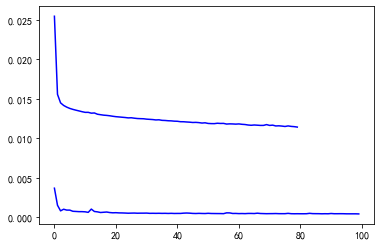

In [13]:
###定义参数取值
n_input =8
n_out =8
q=[0.999]
inv_yhat_list = []
inv_y_list = []
global SplitNum
SplitNum=int((df.shape[0]/int(24*60/abc))*0.7)*int(24*60/abc)-n_input-48*2##天数的百分之0.7,再乘以48
###00前期数据准备
init1,label1,Date1,Xx, Yy,Date1Xx, Date1Yy,initXx, initYy=DataPreprogress(df)
##数据拆分
train_x, test_x,train_y, test_y = split_dataset2(Xx, Yy)#01
inittrain_x, inittest_x,inittrain_y, inittest_y = split_dataset2(initXx, initYy)#01
Datetrain_x, Datetest_x,Datetrain_y, Datetest_y = split_dataset2(Date1Xx, Date1Yy)#01
###01 模型构建（3类模型重复5次）
LSTMQuanModelList=QuanModelListBuild(train_x, train_y,q)

In [14]:
print('int((df.shape[0]/int(24*60/abc))*0.7)*int(24*60/abc)',int((df.shape[0]/int(24*60/abc))*0.7)*int(24*60/abc))

int((df.shape[0]/int(24*60/abc))*0.7)*int(24*60/abc) 7056


In [15]:
###03,测试部分,基于预测模型得到预测值
predictionspredList=PredictValueTest(LSTMQuanModelList,test_x,inittest_y,q)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.85it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.77it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.79it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.88it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.58it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.59it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.54it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.57it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.11it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.61it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.99it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.67it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.88it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.80it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.78it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.79it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.66it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.97it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.86it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.78it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.74it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.69it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.77it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.77it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.61it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.13it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.58it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.60it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.59it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.83it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.78it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.99it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.97it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.78it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.79it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.98it/s]


In [16]:
###04 测试部分，预测结果的传统评价
LSTMPredictScresSet0=ValueTest(test_y,inittest_y,predictionspredList)

In [17]:
ForecastResult = pd.DataFrame(columns = ['Name','RMSE','MSE','MAE']) 
NameList=[]
tqqStr='提前期'+str(int(n_out/2))+'h'+'点预测'
NameList.append(tqqStr)
for i in range(len(q)):
    str0='提前期'+str(int(n_out/2))+'h'+'第'
    str1=str(q[i])
    str2='分位数'
    strall=str0+str1+str2
    NameList.append(strall)
print('NameList',NameList)    
for i in range(1+len(q)):
    ForecastResult0 = pd.DataFrame(columns = ['Name','RMSE','MSE','MAE'])
    ForecastResult0.loc[0,'Name']=NameList[i]
    ForecastResult0.loc[0,'RMSE']=round(LSTMPredictScresSet0[i][0],2)
    ForecastResult0.loc[0,'MSE']=round(LSTMPredictScresSet0[i][1],2)
    ForecastResult0.loc[0,'MAE']=round(LSTMPredictScresSet0[i][2],2)
    ForecastResult=pd.concat([ForecastResult,ForecastResult0], axis=0, ignore_index=True)#axis:合并方式，默认0表示按列合并，1表示按行合并;ignore_index:是否忽略索引                   

NameList ['提前期4h点预测', '提前期4h第0.999分位数']


In [18]:
display(ForecastResult.head(50))

,Name,RMSE,MSE,MAE
0,提前期4h点预测,275.97,76159.1,200.53
1,提前期4h第0.999分位数,1121.43,1.2576e+06,1041.72


#  Determine total cost and service level

## Define functions 

### Get total cost and service level based on the proposed method

In [32]:
def Combine_QHSJPD(ComparResultdf,NameList,djq1,djq2,MeanList1,MeanList2):###djq1表示是点预测或者0.5；djq2表示高分位数
    MeanList=[]
    if djq1==0:##3点预测
        MeanList=MeanList1
    if djq1==2:
        MeanList=MeanList2
    predictionspredList11=[]
    for i in range(len(predictionspredList)):
        predictionspredList11.append([])
        for j in range(len(predictionspredList[i])):
            predictionspredList11[-1].append([])
            for k in range(len(predictionspredList[i][j])):
                predictionspredList11[-1][-1].append([])
                for ij in range(len(predictionspredList[i][j][k])):
                    predictionspredList11[-1][-1][-1].append(0)
                    predictionspredList11[i][j][k][ij]=predictionspredList[i][j][k][ij]#前面没减，就不用了
    df_test1  = df[(df.timestamp>=pd.to_datetime(Datetest_x[0][0][0]))]#df是按照单位时间（abc）聚合后的所有数据
    df_test1.index = pd.DatetimeIndex(df_test1['timestamp'])
    df_testXX=df_test1.iloc[:,0:3]#Date列、以及UnitSales列
    df_testXX['value']=df_testXX['value'].apply(lambda x: x*(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2])+dfghu.iloc[0,2])#减去加的那100
    df_testXX['timestamp'] = pd.to_datetime(df_testXX['timestamp'])#为什么成了选取偶数
    df_testXX['Hour'] = df_testXX['timestamp'].dt.hour.astype("int") #转化提取分钟
    df_testXX['Minute'] = df_testXX['timestamp'].dt.minute.astype("int") #转化提取分钟
    c1=1#c1表示消耗量所在列
    a1=df_testXX.shape[1]
    df_testXX['OurLeaveStock']=df_testXX['timestamp'].apply(lambda x : ReStartStock)#5
    b1=a1+1
    df_testXX['OurBuHuoStart']=df_testXX['timestamp'].apply(lambda x : 0)#补货触发时刻7
    ##参数更新
    def updateCanShu(SSDHCS1,df_testXX,mm,IntervalT,ReStartStock,a1,SSNewTC0,NoOS):#更新参数的自定义函数
        NoOS+=1#
        ActualTimeOS=0
        PredictTimeOS=df_testXX.iloc[mm+3,0]#预测的缺货时刻
        ActualDate=0
        SSDHCS1=SSDHCS1+1
        if df_testXX.iloc[mm,3]+df_testXX.iloc[mm,4]/60==23+(59/60):
            tt=0+IntervalT##tt表示补货到达时刻
            ###11##print('updateCanShu中tt',tt)
        else:
            tt= df_testXX.iloc[mm,3]+df_testXX.iloc[mm,4]/60+IntervalT##tt表示补货到达时刻
            ###11##print('updateCanShu中tt',tt)
        dd=1
        BHVolume=ReStartStock-df_testXX.iloc[mm,a1]#补货量10000-当前库存水平
        SSNewTC0=SSNewTC0+Dcc0#订购一次1500元
        return SSDHCS1,tt,dd,BHVolume,SSNewTC0,NoOS,PredictTimeOS,ActualTimeOS, ActualDate
    ###变动的参数
    hh=1100/(365*24*1378)# 1吨≈1378L，持有成本1100元/吨/年
    tt=0#表示补货时间
    SSDHCS1=0#表示订货次数
    SSNoOfStockout0=0
    dd=0
    ###计算库存成本相关的参数
    tt1=df_testXX.iloc[0,0]#表示上一次补货到达时刻
    ReStartStock00=ReStartStock##初始化周期初，库存水平
    SSNewTC0=0
    global Dcc0
    Dcc0=150#一次订购成本
    ##生成缺货情况表
    dfTimeOutOfStock= pd.DataFrame(columns=('No', 'PredictTime','ActualDate', 'ActualTime','InventoryLevel'))
    NoOS=-1#
    InventoryLevel=0#补货到达时，库存水平
    PredictTimeOS=0#预测的缺货时刻
    ActualDate=0
    ActualTimeOS=0#实际缺货时刻
    ####第一组,重新计算剩余库存以初始化
    for i in range(len(Datetest_x[0])):
        if i==0:
            df_testXX.iloc[i,a1]=df_testXX.iloc[i,a1]-df_testXX.iloc[i,c1]
        else:             
            df_testXX.iloc[i,a1]=df_testXX.iloc[i-1,a1]-df_testXX.iloc[i,c1]#表示剩余库存水平#
    mm=i+1#初始化mm.注，预测的是Datetest_y，其对应的第一组值为 [['2017-03-11T01:30:00.000000000' '2017-03-11T02:00:00.000000000' '2017-03-11T02:30:00.000000000']
    for k in range(1,len(predictionspredList[-1][0]),1): ##除了第一组，后面只取预测的第一个值
        SumDemand=0
        h=0
        for im in range(mm+1,mm+n_input+1,1):
            TimePD = round(df_testXX.iloc[im,3]+ df_testXX.iloc[im,4]/60,1)   #转化为实数版本的小时 
            if TimePD in MeanList:##这个主要判断销量的方差波动性的
                SumDemand+=predictionspredList11[djq1][0][k][h]###这是0.5分位数
            else:
                SumDemand+=predictionspredList11[djq2][0][k][h]
            h+=1  
        SumDemandPus1=SumDemand#SumDemandPus1表示未来2个时段内的总需求
        if k==len(predictionspredList11[djq1][0])-1:
            SumDemandPus1= SumDemandPus1+0#如果是最后一个则+0
        else:
            TimePD = round(df_testXX.iloc[im+1,3]+ df_testXX.iloc[im+1,4]/60,1)  
            if TimePD in MeanList:
                SumDemandPus1+=predictionspredList11[djq1][0][k+1][-1]
            else:
                SumDemandPus1+=predictionspredList11[djq2][0][k+1][-1]
        if SumDemand>= df_testXX.iloc[mm,a1] and tt==0:#（2）去掉了=    
             ###11#####print('\033[0;36m前期没做好，来不及实施应急补货，\033[0m')
             SSDHCS1,tt,dd,BHVolume,SSNewTC0,NoOS,PredictTimeOS,ActualTimeOS,ActualDate=updateCanShu(SSDHCS1,df_testXX,mm,IntervalT,ReStartStock,a1,SSNewTC0,NoOS)
        else:                     
                if SumDemandPus1> df_testXX.iloc[mm,a1] and tt==0:#防止来不及触发补货
                   #print('\033[0;32m不能满足SumDemandPus1导致的缺货时间00为\033[0m',df_testXX.iloc[mm,0])                 
                   SSDHCS1,tt,dd,BHVolume,SSNewTC0,NoOS,PredictTimeOS,ActualTimeOS,ActualDate=updateCanShu(SSDHCS1,df_testXX,mm,IntervalT,ReStartStock,a1,SSNewTC0,NoOS)
                else: 
                    TestDFStockOut2 = DFStockOut[(DFStockOut.timestamp==pd.to_datetime(df_testXX.iloc[mm+1,0]))]#mm确实应该加1###TestDFStockOut2表示未来第一个时段内的所有真实需求
                    TestDFStockOut2 = TestDFStockOut2.sort_values(by=['timestamp'],ascending=[True])#排序
                    singleSumDemand=0
                    for ii in range(TestDFStockOut2.shape[0]):
                        singleSumDemand=singleSumDemand+TestDFStockOut2.iloc[ii,3]                        
                        TimePD = round(df_testXX.iloc[mm+1,3]+ df_testXX.iloc[mm+1,4]/60,1)   #转化为实数版本的小时                         
                        if TimePD in MeanList:
                            BJVALUE0=predictionspredList11[djq1][0][k][0]
                        else:
                            BJVALUE0=predictionspredList11[djq2][0][k][0]
                        if singleSumDemand>=BJVALUE0:#未未来第一个时段内的预测需求####=                          
                            if df_testXX.iloc[mm,a1]-singleSumDemand <= (SumDemand-singleSumDemand )and tt==0: 
                                 ###11#####print('事件驱动下的缺货时间11为',TestDFStockOut2.iloc[ii,0], TestDFStockOut2.iloc[ii,1])
                                 NoOS+=1
                                 PredictTimeOS=TestDFStockOut2.iloc[ii+3,-1]
                                 SSDHCS1=SSDHCS1+1
                                 SSNewTC0=SSNewTC0+Dcc0
                                 tt=TestDFStockOut2.iloc[ii,2]+IntervalT#补货到达时间
                                 ActualTimeOS=0
                                 ActualDate=0
                                 dd=1
                                 BHVolume=ReStartStock-(df_testXX.iloc[mm,a1]-singleSumDemand)#补货量
                                 continue#出现了缺货时间后，这部分就可以不用继续拉                       
    ##02获得实际缺货的时间（主要是防止真实需求的波动性，可能会导致缺货时间发生在补货到达前）
        if tt!=0 and dd==1:##dd==0 or 1用来调节 缺货时间只有一个，库存水平后面不能继续为负
            TestDFStockOut3 = DFStockOut[(DFStockOut.timestamp==pd.to_datetime(df_testXX.iloc[mm+1,0]))]###TestDFStockOut2表示未来第一个时段内的所有真实需求
            TestDFStockOut3 = TestDFStockOut3.sort_values(by=['timestamp'],ascending=[True])#排序
            singleSumDemand1=0
            for ii in range(TestDFStockOut3.shape[0]):
                singleSumDemand1=singleSumDemand1+TestDFStockOut3.iloc[ii,3]
                if df_testXX.iloc[mm,a1]-singleSumDemand1 <= 0 and dd==1:
                    SSNoOfStockout0=SSNoOfStockout0+1#该参数表示实际缺货次数
                    ####11####print('\033[0;35m实际缺货时间是\033[0m',TestDFStockOut3.iloc[ii,0], TestDFStockOut3.iloc[ii,1])
                    ActualTimeOS= TestDFStockOut3.iloc[ii,1]
                    ActualDate= TestDFStockOut3.iloc[ii,0]
                    ###11##print('此时的库存水平',df_testXX.iloc[mm,a1]-singleSumDemand1) 
                    dd=2
    ###03 该部分类似于更新，补货到达事件和库存消耗事件  
        mm=mm+1#向前滚动一个时间单位, 应该放到最后
        BJtt = df_testXX.iloc[mm,3]+ df_testXX.iloc[mm,4]/60   #转化为实数版本的小时 
        if tt!=0: ###补货到达 （BJtt为大于tt的最小时间）
            if tt>=24.0:###对于补货到达时间是24.5、25等情况怎么处理
                if BJtt==23+(59/60):
                    tt=tt-24
                    BJtt=0
                    ###11##print('补货到达时刻为',df_testXX.iloc[mm,0], BJtt)##tt才是补货到达时刻
                    ###11##print('tt',tt)##tt才是补货到达时刻
            if tt<=BJtt: ###补货到达 （BJtt为大于tt的最小时间）
                if dd==2:
                     ###11##print('\033[5;35m之前出现了缺货，但货物在该时间戳内到达\033[0m')#说明前面就出现了缺货,即(df_testXX.iloc[mm-1,a1]-df_testXX.iloc[mm,c1]<0)，而库存水平≥0，所以令其为0
                     df_testXX.iloc[mm-1,a1]=0
                     df_testXX.iloc[mm,a1]=ReStartStock
                     InventoryLevel=0
                     TimeOfDiff=(((df_testXX.iloc[mm,0]-tt1).days)*24+(((df_testXX.iloc[mm,0]-tt1).seconds)/60)/60)#两次补货之间的时间差
                     CYC00=hh*TimeOfDiff*((ReStartStock00+(df_testXX.iloc[mm-1,a1]))/2)#持有成本
                else:#补货到达后的库存水平变化
                    df_testXX.iloc[mm,a1]=ReStartStock
                    InventoryLevel=df_testXX.iloc[mm-1,a1]-df_testXX.iloc[mm,c1]##补货到达时、但还没有补货的库存水平
                    TimeOfDiff=(((df_testXX.iloc[mm,0]-tt1).days)*24+(((df_testXX.iloc[mm,0]-tt1).seconds)/60)/60)#两次补货之间的时间差
                    CYC00=hh* TimeOfDiff*((ReStartStock00+InventoryLevel)/2)#持有成本            
                ###11##print('No\PredictTim\\ActualDate\ActualTime\InventoryLevel',NoOS, PredictTimeOS,ActualDate,ActualTimeOS,InventoryLevel)
                new=pd.DataFrame({'No':NoOS, 'PredictTime':PredictTimeOS,'ActualDate':ActualDate,'ActualTime':ActualTimeOS,'InventoryLevel':InventoryLevel},index=[1]) 
                dfTimeOutOfStock=dfTimeOutOfStock.append(new,ignore_index=True)         
                ReStartStock00=df_testXX.iloc[mm,a1]#变量ReStartStock00表示新周期的初始库存
                tt1=df_testXX.iloc[mm,0]#代表上一次补货时+
                SSNewTC0=SSNewTC0+CYC00
                tt=0   
                dd=0#用以表示    
            else: ###没发出补货或者补货没有到达
                if dd==2:###库存水平降为0
                    ###11##print('\033[1;35m出现了缺货，但货物还没到达\033[0m')
                    df_testXX.iloc[mm,a1]=0##说明前面就出现了缺货，系统停止，库存水平为0
                    continue#说明实际到了缺货时间，系统停止，下面循环不用走
                else:##事件驱动库存消耗
                    df_testXX.iloc[mm,a1]=df_testXX.iloc[mm-1,a1]-df_testXX.iloc[mm,c1]#因为是滚动一个单位向前的，所以要这样  
        else: ###没发出补货或者补货没有到达
                if dd==2:###库存水平降为0
                    ###11##print('\033[1;35m出现了缺货，但货物还没到达\033[0m')
                    df_testXX.iloc[mm,a1]=0##说明前面就出现了缺货，系统停止，库存水平为0
                    continue#说明实际到了缺货时间，系统停止，下面循环不用走
                else:##事件驱动库存消耗
                    df_testXX.iloc[mm,a1]=df_testXX.iloc[mm-1,a1]-df_testXX.iloc[mm,c1]#因为是滚动一个单位向前的，所以要这样 
        if k==len(predictionspredList[-1][0])-1:
            InventoryLevel=max(df_testXX.iloc[mm-1,a1]-df_testXX.iloc[mm,c1],0)
            TimeOfDiff=(((df_testXX.iloc[mm,0]-tt1).days)*24+(((df_testXX.iloc[mm,0]-tt1).seconds)/60)/60)#两次补货之间的时间差
            CYC00=hh* TimeOfDiff*((ReStartStock00+InventoryLevel)/2)#持有成本
            SSNewTC0=SSNewTC0+CYC00  
    ComparResultdf1 = pd.DataFrame(columns=['name','Number of replenishment','Inventory Cost','Delivery Cost','Total Cost','Number of Stock-out'])
    ComparResultdf1.loc[0,'name']=NameList[djq1]+NameList[djq2]
    ComparResultdf1.loc[0,'Number of replenishment']=SSDHCS1#DHCS1
    ComparResultdf1.loc[0,'Inventory Cost']=round(SSNewTC0,2)
    ComparResultdf1.loc[0,'Delivery Cost']=round(SSDHCS1*(213+1.83*50),2)
    ComparResultdf1.loc[0,'Total Cost']=round(SSNewTC0+SSDHCS1*(213+1.83*50),2)
    ComparResultdf1.loc[0,'Number of Stock-out']=SSNoOfStockout0
    ComparResultdf=pd.concat([ComparResultdf,ComparResultdf1], axis=0, ignore_index=True)#axis:合并方式，默认0表示按列合并，1表示按行合并;ignore_index:是否忽略索引                   
    return ComparResultdf

### Get total cost and service level based on the single model

In [33]:
def SingleQHSJPD(ComparResultdf,NameList,djq):###djq表示在模型中属于第几个
    predictionspredList11=[]
    for i in range(len(predictionspredList)):
        predictionspredList11.append([])
        for j in range(len(predictionspredList[i])):
            predictionspredList11[-1].append([])
            for k in range(len(predictionspredList[i][j])):
                predictionspredList11[-1][-1].append([])
                for ij in range(len(predictionspredList[i][j][k])):
                    predictionspredList11[-1][-1][-1].append(0)
                    predictionspredList11[i][j][k][ij]=predictionspredList[i][j][k][ij]#前面没减，就不用了
    df_test1  = df[(df.timestamp>=pd.to_datetime(Datetest_x[0][0][0]))]#df是按照单位时间（abc）聚合后的所有数据
    df_test1.index = pd.DatetimeIndex(df_test1['timestamp'])
    df_testXX=df_test1.iloc[:,0:3]#Date列、以及UnitSales列
    df_testXX['value']=df_testXX['value'].apply(lambda x: x*(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2])+dfghu.iloc[0,2])#减去加的那100
    df_testXX['timestamp'] = pd.to_datetime(df_testXX['timestamp'])#为什么成了选取偶数
    df_testXX['Hour'] = df_testXX['timestamp'].dt.hour.astype("int") #转化提取分钟
    df_testXX['Minute'] = df_testXX['timestamp'].dt.minute.astype("int") #转化提取分钟
    c1=1#c1表示消耗量所在列
    a1=df_testXX.shape[1]
    df_testXX['OurLeaveStock']=df_testXX['timestamp'].apply(lambda x : ReStartStock)#5
    b1=a1+1
    df_testXX['OurBuHuoStart']=df_testXX['timestamp'].apply(lambda x : 0)#补货触发时刻7
    
        ###参数更新
    def updateCanShu(DHCS1,df_testXX,mm,IntervalT,ReStartStock,a1,NewTC0,NoOS):#更新参数的自定义函数
        NoOS+=1#
        ActualTimeOS=0
        PredictTimeOS=df_testXX.iloc[mm+3,0]#预测的缺货时刻
        ActualDate=0
        DHCS1=DHCS1+1
        if df_testXX.iloc[mm,3]+df_testXX.iloc[mm,4]/60==23+(59/60):       
            tt=0+IntervalT##tt表示补货到达时刻
            ###11##print('00中tt',tt)
        else:
            tt= df_testXX.iloc[mm,3]+df_testXX.iloc[mm,4]/60+IntervalT##tt表示补货到达时刻
            ###11##print('11中tt',tt)
        dd=1
        BHVolume=ReStartStock-df_testXX.iloc[mm,a1]#补货量10000-当前库存水平
        NewTC0=NewTC0+Dcc0#订购一次1500元
        return DHCS1,tt,dd,BHVolume,NewTC0,NoOS,PredictTimeOS,ActualTimeOS, ActualDate
    ###变动的参数
    hh=1100/(365*24*1378)# 1吨≈1378L，持有成本1100元/吨/年
    tt=0#表示补货时间
    DHCS1=0#表示订货次数
    NoOfStockout0=0
    dd=0
    ###计算库存成本相关的参数
    tt1=df_testXX.iloc[0,0]#表示上一次补货到达时刻
    ReStartStock00=ReStartStock##初始化周期初，库存水平
    NewTC0=0
    global Dcc0
    Dcc0=150#一次订购成本
    ##生成缺货情况表
    dfTimeOutOfStock= pd.DataFrame(columns=('No', 'PredictTime','ActualDate', 'ActualTime','InventoryLevel'))
    NoOS=-1#
    InventoryLevel=0#补货到达时，库存水平
    PredictTimeOS=0#预测的缺货时刻
    ActualDate=0
    ActualTimeOS=0#实际缺货时刻
    ####第一组,重新计算剩余库存以初始化
    for i in range(len(Datetest_x[0])):
        if i==0:
            df_testXX.iloc[i,a1]=df_testXX.iloc[i,a1]-df_testXX.iloc[i,c1]
        else:             
            df_testXX.iloc[i,a1]=df_testXX.iloc[i-1,a1]-df_testXX.iloc[i,c1]#表示剩余库存水平#
    ###11##print('df_testXX.iloc[mm,a1]',df_testXX.iloc[0,a1])
    mm=i+1#初始化mm.注，预测的是Datetest_y，其对应的第一组值为 [['2017-03-11T01:30:00.000000000' '2017-03-11T02:00:00.000000000' '2017-03-11T02:30:00.000000000']
    ###我的预测方法下预测的缺货时间
    ###11##print('我的预测方法下预测的缺货时间')
    for k in range(1,len(predictionspredList[-1][0]),1): ##除了第一组，后面只取预测的第一个值
    ##00未来需求的求和，对应step3                
        SumDemand=0##SumDemand表示未来1个时段内的总需求
        for h in range(len(predictionspredList11[djq][0][k])):
            SumDemand=SumDemand+predictionspredList11[djq][0][k][h]       
        SumDemandPus1=SumDemand
        if k==len(predictionspredList[-1][0])-1:
            SumDemandPus1= SumDemandPus1+0#如果是最后一个则+0
        else:
            SumDemandPus1= SumDemandPus1+predictionspredList11[djq][0][k+1][-1]#只需向前多滚动一个单位时间即可
        if SumDemand>=df_testXX.iloc[mm,a1] and tt==0:#tt=0表示首次补货
             ###11##print('\033[0;36m前期没做好，来不及实施应急补货，\033[0m')
             DHCS1,tt,dd,BHVolume,NewTC0,NoOS,PredictTimeOS,ActualTimeOS,ActualDate=updateCanShu(DHCS1,df_testXX,mm,IntervalT,ReStartStock,a1,NewTC0,NoOS)
        else:                   
                if SumDemandPus1>df_testXX.iloc[mm,a1] and tt==0:#（2）去掉了=
                     ###11##print('\033[0;32m不能满足SumDemandPus1导致的缺货时间00为\033[0m',df_testXX.iloc[mm,0])                 
                     DHCS1,tt,dd,BHVolume,NewTC0,NoOS,PredictTimeOS,ActualTimeOS,ActualDate=updateCanShu(DHCS1,df_testXX,mm,IntervalT,ReStartStock,a1,NewTC0,NoOS)
                else:                
                    TestDFStockOut2 = DFStockOut[(DFStockOut.timestamp==pd.to_datetime(df_testXX.iloc[mm+1,0]))]#mm确实应该加1###TestDFStockOut2表示未来第一个时段内的所有真实需求
                    ###TestDFStockOut2表示未来第一个时段内的所有真实需求
                    TestDFStockOut2 = TestDFStockOut2.sort_values(by=['timestamp'],ascending=[True])#排序
                    singleSumDemand=0
                    for ii in range(TestDFStockOut2.shape[0]):
                        singleSumDemand=singleSumDemand+TestDFStockOut2.iloc[ii,3]
                        if singleSumDemand>=predictionspredList11[djq][0][k][0]:#未未来第一个时段内的预测需求
                            if df_testXX.iloc[mm,a1]-singleSumDemand <= (SumDemand-singleSumDemand )and tt==0:
                                 ####11##print('事件驱动下的缺货时间11为',TestDFStockOut2.iloc[ii,0], TestDFStockOut2.iloc[ii,1])
                                 NoOS+=1
                                 PredictTimeOS=TestDFStockOut2.iloc[ii+3,-1]
                                 DHCS1=DHCS1+1
                                 NewTC0=NewTC0+Dcc0
                                 tt=TestDFStockOut2.iloc[ii,2]+IntervalT#补货到达时间
                                 ActualTimeOS=0
                                 ActualDate=0
                                 dd=1
                                 BHVolume=ReStartStock-(df_testXX.iloc[mm,a1]-singleSumDemand)#补货量
                                 continue#出现了缺货时间后，这部分就可以不用继续拉                       
    ##02获得实际缺货的时间（主要是防止真实需求的波动性，可能会导致缺货时间发生在补货到达前）
        if tt!=0 and dd==1:##dd==0 or 1用来调节 缺货时间只有一个，库存水平后面不能继续为负
            TestDFStockOut3 = DFStockOut[(DFStockOut.timestamp==pd.to_datetime(df_testXX.iloc[mm+1,0]))]###TestDFStockOut2表示未来第一个时段内的所有真实需求
            TestDFStockOut3 = TestDFStockOut3.sort_values(by=['timestamp'],ascending=[True])#排序
            singleSumDemand1=0
            for ii in range(TestDFStockOut3.shape[0]):
                singleSumDemand1=singleSumDemand1+TestDFStockOut3.iloc[ii,3]
                if df_testXX.iloc[mm,a1]-singleSumDemand1 <= 0 and dd==1:
                    NoOfStockout0=NoOfStockout0+1#该参数表示实际缺货次数
                    ###11##print('\033[0;35m实际缺货时间是\033[0m',TestDFStockOut3.iloc[ii,0], TestDFStockOut3.iloc[ii,1])
                    ActualTimeOS= TestDFStockOut3.iloc[ii,1]
                    ActualDate= TestDFStockOut3.iloc[ii,0]
                    ###11##print('此时的库存水平',df_testXX.iloc[mm,a1]-singleSumDemand1) 
                    dd=2#用来调节库存最小为0，不能为负
    ###03 该部分类似于更新，补货到达事件和库存消耗事件  
        mm=mm+1#向前滚动一个时间单位, 应该放到最后
        BJtt = df_testXX.iloc[mm,3]+ df_testXX.iloc[mm,4]/60   #转化为实数版本的小时  
        if tt!=0: ###补货到达 （BJtt为大于tt的最小时间）
            if tt>=24.0:###对于补货到达时间是24.5、25等情况怎么处理
                if BJtt==23+(59/60):
                    tt=tt-24
                    BJtt=0
                    ###11##print('补货到达时刻为',df_testXX.iloc[mm,0], BJtt)##tt才是补货到达时刻
                    ###11##print('tt',tt)##tt才是补货到达时刻
            if tt<=BJtt: ###补货到达 （BJtt为大于tt的最小时间）
                if dd==2:
                     ###11##print('\033[5;35m之前出现了缺货，但货物在该时间戳内到达\033[0m')#说明前面就出现了缺货,即(df_testXX.iloc[mm-1,a1]-df_testXX.iloc[mm,c1]<0)，而库存水平≥0，所以令其为0
                     df_testXX.iloc[mm-1,a1]=0
                     #df_testXX.iloc[mm,a1]=0+BHVolume
                     df_testXX.iloc[mm,a1]=ReStartStock
                     InventoryLevel=0
                     TimeOfDiff=(((df_testXX.iloc[mm,0]-tt1).days)*24+(((df_testXX.iloc[mm,0]-tt1).seconds)/60)/60)#两次补货之间的时间差
                     CYC00=hh*TimeOfDiff*((ReStartStock00+(df_testXX.iloc[mm-1,a1]))/2)#持有成本
                else:#补货到达后的库存水平变化
                    df_testXX.iloc[mm,a1]=ReStartStock
                    InventoryLevel=df_testXX.iloc[mm-1,a1]-df_testXX.iloc[mm,c1]
                    TimeOfDiff=(((df_testXX.iloc[mm,0]-tt1).days)*24+(((df_testXX.iloc[mm,0]-tt1).seconds)/60)/60)#两次补货之间的时间差
                    CYC00=hh* TimeOfDiff*((ReStartStock00+InventoryLevel)/2)#持有成本
                ###11##print('No\PredictTim\\ActualDate\ActualTime\InventoryLevel',NoOS, PredictTimeOS,ActualDate,ActualTimeOS,InventoryLevel)
                new=pd.DataFrame({'No':NoOS, 'PredictTime':PredictTimeOS,'ActualDate':ActualDate,'ActualTime':ActualTimeOS,'InventoryLevel':InventoryLevel},index=[1]) 
                dfTimeOutOfStock=dfTimeOutOfStock.append(new,ignore_index=True) 
                ReStartStock00=df_testXX.iloc[mm,a1]#变量ReStartStock00表示新周期的初始库存
                tt1=df_testXX.iloc[mm,0]#代表上一次补货时+
                NewTC0=NewTC0+CYC00
                tt=0   
                dd=0#用以表示    
            else: ###没发出补货或者补货没有到达
                if dd==2:###库存水平降为0
                    ###11##print('\033[1;35m出现了缺货，但货物还没到达\033[0m')
                    df_testXX.iloc[mm,a1]=0##说明前面就出现了缺货，系统停止，库存水平为0
                    continue#说明实际到了缺货时间，系统停止，下面循环不用走
                else:##事件驱动库存消耗
                    df_testXX.iloc[mm,a1]=df_testXX.iloc[mm-1,a1]-df_testXX.iloc[mm,c1]#因为是滚动一个单位向前的，所以要这样 
        else: ###没发出补货或者补货没有到达
                if dd==2:###库存水平降为0
                    ###11##print('\033[1;35m出现了缺货，但货物还没到达\033[0m')
                    df_testXX.iloc[mm,a1]=0##说明前面就出现了缺货，系统停止，库存水平为0
                    continue#说明实际到了缺货时间，系统停止，下面循环不用走
                else:##事件驱动库存消耗
                    df_testXX.iloc[mm,a1]=df_testXX.iloc[mm-1,a1]-df_testXX.iloc[mm,c1]#因为是滚动一个单位向前的，所以要这样 
        if k==len(predictionspredList[-1][0])-1:
            InventoryLevel=max(df_testXX.iloc[mm-1,a1]-df_testXX.iloc[mm,c1],0)
            TimeOfDiff=(((df_testXX.iloc[mm,0]-tt1).days)*24+(((df_testXX.iloc[mm,0]-tt1).seconds)/60)/60)#两次补货之间的时间差
            CYC00=hh* TimeOfDiff*((ReStartStock00+InventoryLevel)/2)#持有成本
            NewTC0=NewTC0+CYC00
    ####################将结果写入dataframe###################################
    ComparResultdf1 = pd.DataFrame(columns=['name','Number of replenishment','Inventory Cost','Delivery Cost','Total Cost','Number of Stock-out'])
    ComparResultdf1.loc[0,'name']=NameList[djq]
    ComparResultdf1.loc[0,'Number of replenishment']=DHCS1
    ComparResultdf1.loc[0,'Inventory Cost']=round(NewTC0,2)
    ComparResultdf1.loc[0,'Delivery Cost']=round(DHCS1*(213+1.83*50),2)
    ComparResultdf1.loc[0,'Total Cost']=round(NewTC0+DHCS1*(213+1.83*50),2)
    ComparResultdf1.loc[0,'Number of Stock-out']=NoOfStockout0
    ComparResultdf=pd.concat([ComparResultdf,ComparResultdf1], axis=0, ignore_index=True)#axis:合并方式，默认0表示按列合并，1表示按行合并;ignore_index:是否忽略索引                   
    return ComparResultdf

##  Calculating Result

In [34]:
df_Hour = df3[['MinuteLabel','UnitSales','weekday','day_name']]
df_Hour['MinuteLabel']=df_Hour['MinuteLabel'].astype(int)#得转换为整数形才排序
df_Hour.sort_values(by=['MinuteLabel'],ascending=[True])  # 按时间排序

D:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MinuteLabel,UnitSales,weekday,day_name
0,0,0.006636,0,Monday
1056,0,0.025550,0,Monday
6000,0,0.000000,4,Friday
7632,0,0.041587,5,Saturday
1248,0,0.023993,0,Monday
...,...,...,...,...
5279,47,0.062176,3,Thursday
3839,47,0.034624,2,Wednesday
2351,47,0.050401,1,Tuesday
6767,47,0.096435,4,Friday


In [35]:
print('n_input',n_input)

n_input 8


In [36]:
df_test1  = df[(df.timestamp>=pd.to_datetime(Datetest_x[0][0][0]))]#df是按照单位时间（abc）聚合后的所有数据
df_test1.index = pd.DatetimeIndex(df_test1['timestamp'])
TestDFStockOut1  =  DFStockOut[(DFStockOut.timestamp>=pd.to_datetime(Datetest_y[0][0]))]
TestDFStockOut1.index = pd.DatetimeIndex(TestDFStockOut1['timestamp'])
ReStartStock=60000#44128#34475#13790#该变量表示补货到达后的初始库存，1吨92#汽油=1379L
IntervalT=n_input/2
ComparResultdf01 = pd.DataFrame(columns = ['Number of replenishment','Inventory Cost','Delivery Cost','Total Cost','Number of Stock-out']) 
MeanList1,MeanList2,DegreeOfDispersionResult00=AllCalCu_Member(df_Hour,0.999)###只在djq2处计算即可
for djq2 in range(len(NameList)):
    if djq2!=0:
        print('q[djq2-1]',q[djq2-1])
        ##MeanList1对应点预测
        MeanList1.append(24.0)
        MeanList2.append(24.0)
        for djq1 in [0]:
            ComparResultdf01= Combine_QHSJPD(ComparResultdf01,NameList,djq1,djq2,MeanList1,MeanList2)
        ComparResultdf01=SingleQHSJPD(ComparResultdf01,NameList,djq2)###点预测没有CQR值
        display(ComparResultdf01.tail(4))
for djq in [0]:
    ComparResultdf01=SingleQHSJPD(ComparResultdf01,NameList,djq)
str0='前期'+str(int(n_out/2))+'h'+'第'
str1='350+285_点和分位数预测选择NNOO的超参数_无Dropout层_Trail100_Hyperparameter_ConstantMeanList_ComparResultdf60000.csv'
ComparResultdf01.to_csv(str0+str1)

q[djq2-1] 0.999


,Number of replenishment,Inventory Cost,Delivery Cost,Total Cost,Number of Stock-out,name
0,43,11293.7,13093.5,24387.2,0,提前期4h点预测提前期4h第0.999分位数
1,44,11562,13398,24960,0,提前期4h第0.999分位数


# Evaluation Metrics

##   Define functions

In [42]:
#########区间预测评价指标#############
import numpy as np
from sklearn import metrics
# MAPE和SMAPE需要自己实现
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100
def trimData(test_y1,predictionspred):### 求和
    test_y=[]
    predictions=[]
    SumSW=0
    for i in range(len(test_y1)):
        sumtest=0
        sumpred=0
        for j in range(len(test_y1[i])):
            sumtest+=test_y1[i][j]
            sumpred+=predictionspred[i][j]
        test_y.append(sumtest)
        predictions.append(sumpred)
    return np.array(test_y),np.array(predictions)

def NewNewMSE0(test_y1,predictionspred):
    predictionspred0=np.array(predictionspred) 
    RMSE,scores,MSE,MAE,MAPE,AllNum=evaluate_forecasts1(test_y1[:, :],predictionspred0)###这些没求和
    y_true,y_pred=trimData(test_y1,predictionspred0)
    in_the_range = np.sum(y_true<= y_pred)##该值表示
    PIP=in_the_range/len(y_true)
    PIP=str(100*PIP)[:4]+ '%'  
    sumSMAPe=0 
    a=5
    for i in range(len(y_true)):
        if y_true[i]>y_pred[i]: 
            sumSMAPe+=a*abs(y_true[i]-y_pred[i])/((abs(y_true[i])+abs(y_pred[i]))/2)          
        else:
            sumSMAPe+=abs(y_true[i]-y_pred[i])/((abs(y_true[i])+abs(y_pred[i]))/2)  
    SMAPE=sumSMAPe/len(y_true)                  
    MSE=round(MSE,2)
    RMSE=round(RMSE,2)
    MAE=round(MAE,2)
    MAPE=round(MAPE,2)
    SMAPE=round(SMAPE,2)
    return MSE,RMSE,MAE,MAPE,SMAPE,PIP  
def q_loss0(qq,test_y1,predictionspred):### 定义分位数损失函数
    SumSW=0
    for i in range(len(test_y1)):
        for j in range(len(test_y1[i])):
            e=predictionspred[i][j]-test_y1[i][j]
            if e>=0:
               qLoss=(1-qq)*e
            else:
               qLoss=qq*(-e)
            SumSW+=qLoss
    return round(SumSW, 4)
def AccuracyResult_Single(LimitForecastResultLatest,NameStr,test_y1,SetData,qq):
    MSE,RMSE,MAE,MAPE,SMAPE,PIP=NewNewMSE0(test_y1,SetData)
    ALLq_loss=q_loss0(qq,test_y1,SetData)
    LimitForecastResultLatest0 = pd.DataFrame(columns = ['Name','RMSE','MAE','q_loss'])
    LimitForecastResultLatest0.loc[0,'Name']=NameStr
    LimitForecastResultLatest0.loc[0,'RMSE']=RMSE
    LimitForecastResultLatest0.loc[0,'MAE']=MAE
    LimitForecastResultLatest0.loc[0,'Allq_loss']=ALLq_loss
    LimitForecastResultLatest0.loc[0,'q_loss']=round(ALLq_loss/(len(test_y1)*len(test_y1[0])), 4)
    LimitForecastResultLatest=pd.concat([LimitForecastResultLatest,LimitForecastResultLatest0], axis=0, ignore_index=True)#axis:合并方式，默认0表示按列合并，1表示按行合并;ignore_index:是否忽略索引                   
    return LimitForecastResultLatest

## Determine forecasted values of our proposed method 

In [43]:
df_testXX=df_test1.iloc[:,0:3]#Date列、以及UnitSales列
df_testXX['value']=df_testXX['value'].apply(lambda x: x*(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2])+dfghu.iloc[0,2])#减去加的那100
df_testXX['timestamp'] = pd.to_datetime(df_testXX['timestamp'])#为什么成了选取偶数
df_testXX['Hour'] = df_testXX['timestamp'].dt.hour.astype("int") #转化提取分钟
df_testXX['Minute'] = df_testXX['timestamp'].dt.minute.astype("int") #转化提取分钟
c1=1#c1表示消耗量所在列
a1=df_testXX.shape[1]
df_testXX['OurLeaveStock']=df_testXX['timestamp'].apply(lambda x : ReStartStock)#5
b1=a1+1
df_testXX['OurBuHuoStart']=df_testXX['timestamp'].apply(lambda x : 0)#补货触发时刻7
predictionspredList11=[]
for i in range(len(predictionspredList)):
    predictionspredList11.append([])
    for j in range(len(predictionspredList[i])):
        predictionspredList11[-1].append([])
        for k in range(len(predictionspredList[i][j])):
            predictionspredList11[-1][-1].append([])
            for ij in range(len(predictionspredList[i][j][k])):
                predictionspredList11[-1][-1][-1].append(0)
                predictionspredList11[i][j][k][ij]=predictionspredList[i][j][k][ij]#前面没减，就不用了
MeanList1,MeanList2,DegreeOfDispersionResult0=AllCalCu_Member(df_Hour,0.999)###只在djq2处计算即可
NewpredictionspredList00=[]
for djq2 in range(len(NameList)):
    if djq2!=0:
        print('q[djq2-1]',q[djq2-1])
        for djq1 in [0]:
            if djq1==0:##3点预测
                MeanList=MeanList1
            if djq1==2:
                MeanList=MeanList2
            NewpredictionspredList00.append([])
            NewpredictionspredList00[-1].append([])
            nmm=0
            for k in range(len(predictionspredList[-1][0])): ##除了第一组，后面只取预测的第一个值
                h=0
                NewpredictionspredList00[-1][0].append([])#只需向前多滚动一个单位时间即可
                for im in range(nmm,nmm+n_input,1):
                    #print(df_testXX.iloc[im,:])
                    TimePD = round(df_testXX.iloc[im,3]+ df_testXX.iloc[im,4]/60,1)   #转化为实数版本的小时 
                    if TimePD in MeanList:##这个主要判断销量的方差波动性的            
                        NewpredictionspredList00[-1][0][-1].append(predictionspredList11[djq1][0][k][h])
                    else:            
                        NewpredictionspredList00[-1][0][-1].append(predictionspredList11[djq2][0][k][h])
                    h+=1    
                nmm+=1
print('len(NewpredictionspredList00)',len(NewpredictionspredList00))     

q[djq2-1] 0.999
len(NewpredictionspredList00) 1


## Result of Evaluation Metrics 

In [44]:
inv_yhat_list = []
inv_y_list = []
global SplitNum
SplitNum=int((df.shape[0]/int(24*60/abc))*0.7)*int(24*60/abc)-n_input-48*2##天数的百分之0.7,再乘以48
###00前期数据准备
init1,label1,Date1,Xx, Yy,Date1Xx, Date1Yy,initXx, initYy=DataPreprogress(df)
##数据拆分
train_x, test_x,train_y, test_y = split_dataset2(Xx, Yy)#01
print('len(train_x), len(test_x),len(train_y), len(test_y)',len(train_x), len(test_x),len(train_y), len(test_y))
print(len(Xx), len(Yy))
inittrain_x, inittest_x,inittrain_y, inittest_y = split_dataset2(initXx, initYy)#01
Datetrain_x, Datetest_x,Datetrain_y, Datetest_y = split_dataset2(Date1Xx, Date1Yy)#01
test_y1=test_y.copy()## 对原始的array1的复制
for i in range(test_y.shape[0]):
    test_y1[i, :]=(test_y[i, :] + inittest_y[i,:])*(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2])+dfghu.iloc[0,2]#不用求exp啦
bb=1000##bb=len(test_y1)表示所有数据

len(train_x), len(test_x),len(train_y), len(test_y) 6952 3113 6952 3113
10065 10065


In [45]:
LimitForecastResultLatest = pd.DataFrame(columns = ['Name','RMSE','MAE','q_loss'])
xhi=0
for djq2 in range(len(NameList)):
    if djq2!=0:
        qq=q[djq2-1]
        for djq1 in [0]:
            SetData=NewpredictionspredList00[xhi][0]
            NameStr=NameList[djq1]+NameList[djq2]
            LimitForecastResultLatest=AccuracyResult_Single(LimitForecastResultLatest,NameStr,test_y1,SetData,qq)
        
        #####单独分位数
        SetData=predictionspredList[djq2][0]
        NameStr=NameList[djq2]
        LimitForecastResultLatest=AccuracyResult_Single(LimitForecastResultLatest,NameStr,test_y1,SetData,qq)   
        xhi+=1
for djq in [0]:
   #####单独分位数
    SetData=predictionspredList[djq][0]
    NameStr=NameList[djq]
    qq=0.5
    LimitForecastResultLatest=AccuracyResult_Single(LimitForecastResultLatest,NameStr,test_y1,SetData,qq) 
str0='提前期'+str(int(n_out/2))+'h'+'第'
str1='350+285_点和分位数预测选择NNOO的超参数_无Dropout层_Trail100_Hyperparameter_Single_LimitForecastResultLatest.csv'
LimitForecastResultLatest.to_csv(str0+str1)

In [46]:
display(LimitForecastResultLatest.tail(8))

,Name,RMSE,MAE,q_loss,Allq_loss
0,提前期4h点预测提前期4h第0.999分位数,817,644.18,33.1032,8.244021e+05
1,提前期4h第0.999分位数,1121.43,1041.72,1.1415,2.842898e+04
2,提前期4h点预测,275.97,200.53,100.266,2.497016e+06
